# Building and using data schemas for computer vision
This tutorial illustrates how to use raymon profiling to guard image quality in your production system. The image data is taken from [Kaggle](https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product) and is courtesy of PILOT TECHNOCAST, Shapar, Rajkot. Commercial use of this data is not permitted, but we have received permission to use this data in our tutorials.

Note that some outputs may not work when viewing on Github since they are shown in iframes. We recommend to clone this repo and execute the notebooks locally.

In [1]:
%load_ext autoreload
%autoreload 2

from PIL import Image
from pathlib import Path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, let's load some data. In this tutorial, we'll take the example of quality inspection in manufacturing. The puprose of our system may be to determine whether a manufactured part passes the required quality checks. These checks may measure the roudness of the part, the smoothness of the edges, the smoothness of the part overall, etc... let's assume you have automated those checks with an ML based system.

What we demonstrate here is how you can easily set up quality checks on the incoming data like whether the image is sharp enough and whether it is similar enough to the data the model was trained on. Doing checks like this may be important because people's actions, periodic maintenance and wear and tear may have an impact on what data exaclty is sent to your system. If your data changes, your system may keep running but will suffer from reduced performance, resulting in lower business value.

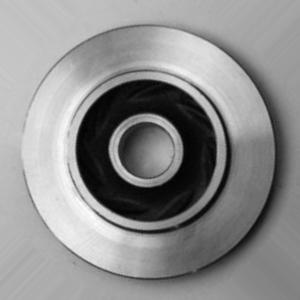

In [2]:
DATA_PATH = Path("./data_sample/castinginspection/ok_front/")
LIM = 150

def load_data(dpath, lim):
    files = dpath.glob("*.jpeg")
    images = []
    for n, fpath in enumerate(files):
        if n == lim:
            break
        img = Image.open(fpath)
        images.append(img)
    return images


loaded_data = load_data(dpath=DATA_PATH, lim=LIM)
loaded_data[0]

## Constructing and building a profile
For this tutorial, we'll construct a profile that checks the image sharpness and will calculate an outlier score on the image. This way, we hope to get alerting when something seems off with the input data.

Just like in the case of structured data, we need to start by specifying a profile and its components. 

In [3]:
from raymon import ModelProfile, InputComponent
from raymon.profiling.extractors.vision import Sharpness, DN2AnomalyScorer


profile = ModelProfile(
    name="casting-inspection",
    version="0.0.1",
    components=[
        InputComponent(name="sharpness", extractor=Sharpness()),
        InputComponent(name="outlierscore", extractor=DN2AnomalyScorer(k=16))
    ],
)

profile.build(input=loaded_data)

In [4]:
## Inspect the schema

In [5]:
profile.view(poi=loaded_data[-1], mode="external")

PosixPath('/var/folders/cn/ht7pqf_j1hg6l7b552dnfvrw0000gn/T/.tmp1qmp1pzm/schema.html')

## Use the profile to check new data
We can save the schema to JSON, load it again (in your production system), and use it to validate incoming data.

In [6]:
profile.save(".")
profile = ModelProfile.load("casting-inspection@0.0.1.json")

tags = profile.validate_input(loaded_data[-1])
tags

[{'type': 'profile-input',
  'name': 'sharpness',
  'value': 4.742788888888889,
  'group': 'casting-inspection@0.0.1'},
 {'type': 'profile-input',
  'name': 'outlierscore',
  'value': 25.64281711808594,
  'group': 'casting-inspection@0.0.1'}]

As you can see, all the extracted feature values are returned. This is useful for when you want to track feature distributions on your monitoring backend (which is what happens on the Raymon.ai platform). Also note that these features are not necessarily the ones going into your ML model.

## Corrupting inputs

Let's see what happens when we blur an image. 

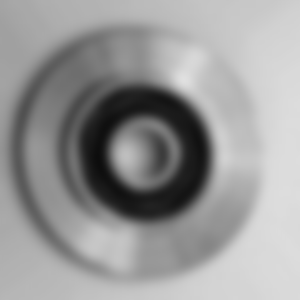

In [7]:
from PIL import ImageFilter

img_blur = loaded_data[-1].copy().filter(ImageFilter.GaussianBlur(radius=5))
img_blur

In [8]:
profile.validate_input(img_blur)

[{'type': 'profile-input',
  'name': 'sharpness',
  'value': 3.024211111111111,
  'group': 'casting-inspection@0.0.1'},
 {'type': 'profile-input-error',
  'name': 'sharpness-error',
  'value': 'LowerBoundError',
  'group': 'casting-inspection@0.0.1'},
 {'type': 'profile-input',
  'name': 'outlierscore',
  'value': 55.694606120008004,
  'group': 'casting-inspection@0.0.1'},
 {'type': 'profile-input-error',
  'name': 'outlierscore-error',
  'value': 'UpperBoundError',
  'group': 'casting-inspection@0.0.1'}]

As can be seen, every feature extractor now gives rise to 2 tags: one being the feature and one being a schema error, indicating that the data has failed both sanity checks. Awesome.

We can visualize this datum while inspecting the profile.

In [9]:
profile.view(poi=img_blur, mode="external")

PosixPath('/var/folders/cn/ht7pqf_j1hg6l7b552dnfvrw0000gn/T/.tmp4foy9wnu/schema.html')

As we can see, the calculated feature values are way outside the range that were seen during training. Having alerting set up for this is crucial to delevier reliable systems.